# 1. Import needed libraries

In [3]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [4]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [5]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')

In [7]:
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [8]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [9]:
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


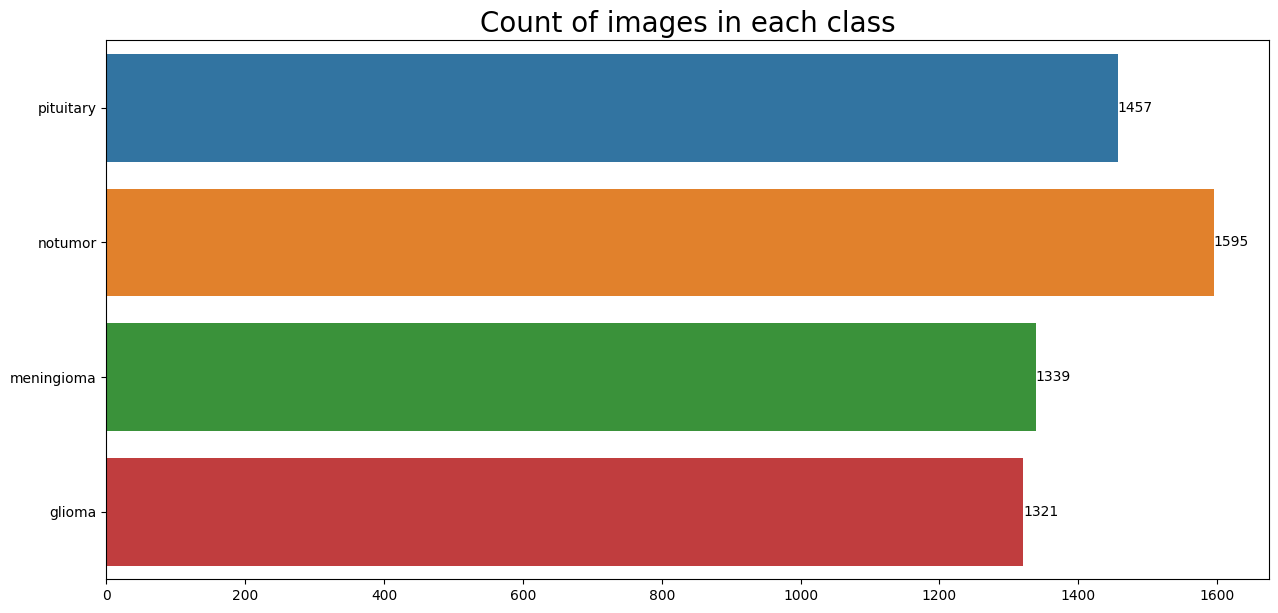

In [10]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

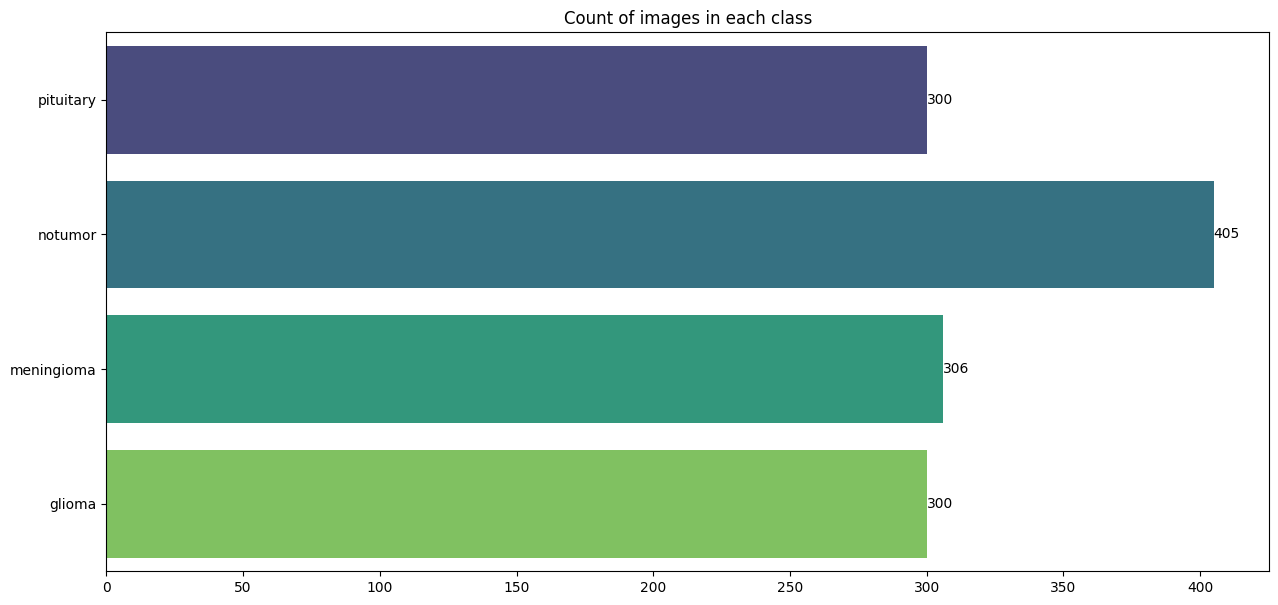

In [11]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [12]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [13]:
valid_df

,Class Path,Class
1297,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
723,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
61,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
778,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
1070,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
554,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1284,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
899,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


## 2.3 Data preprocessing

In [14]:
batch_size = 32
img_size = (128, 128)

_gen = ImageDataGenerator(rescale=1/255,
                         # brightness_range=(0.8, 1.2)
                         )

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

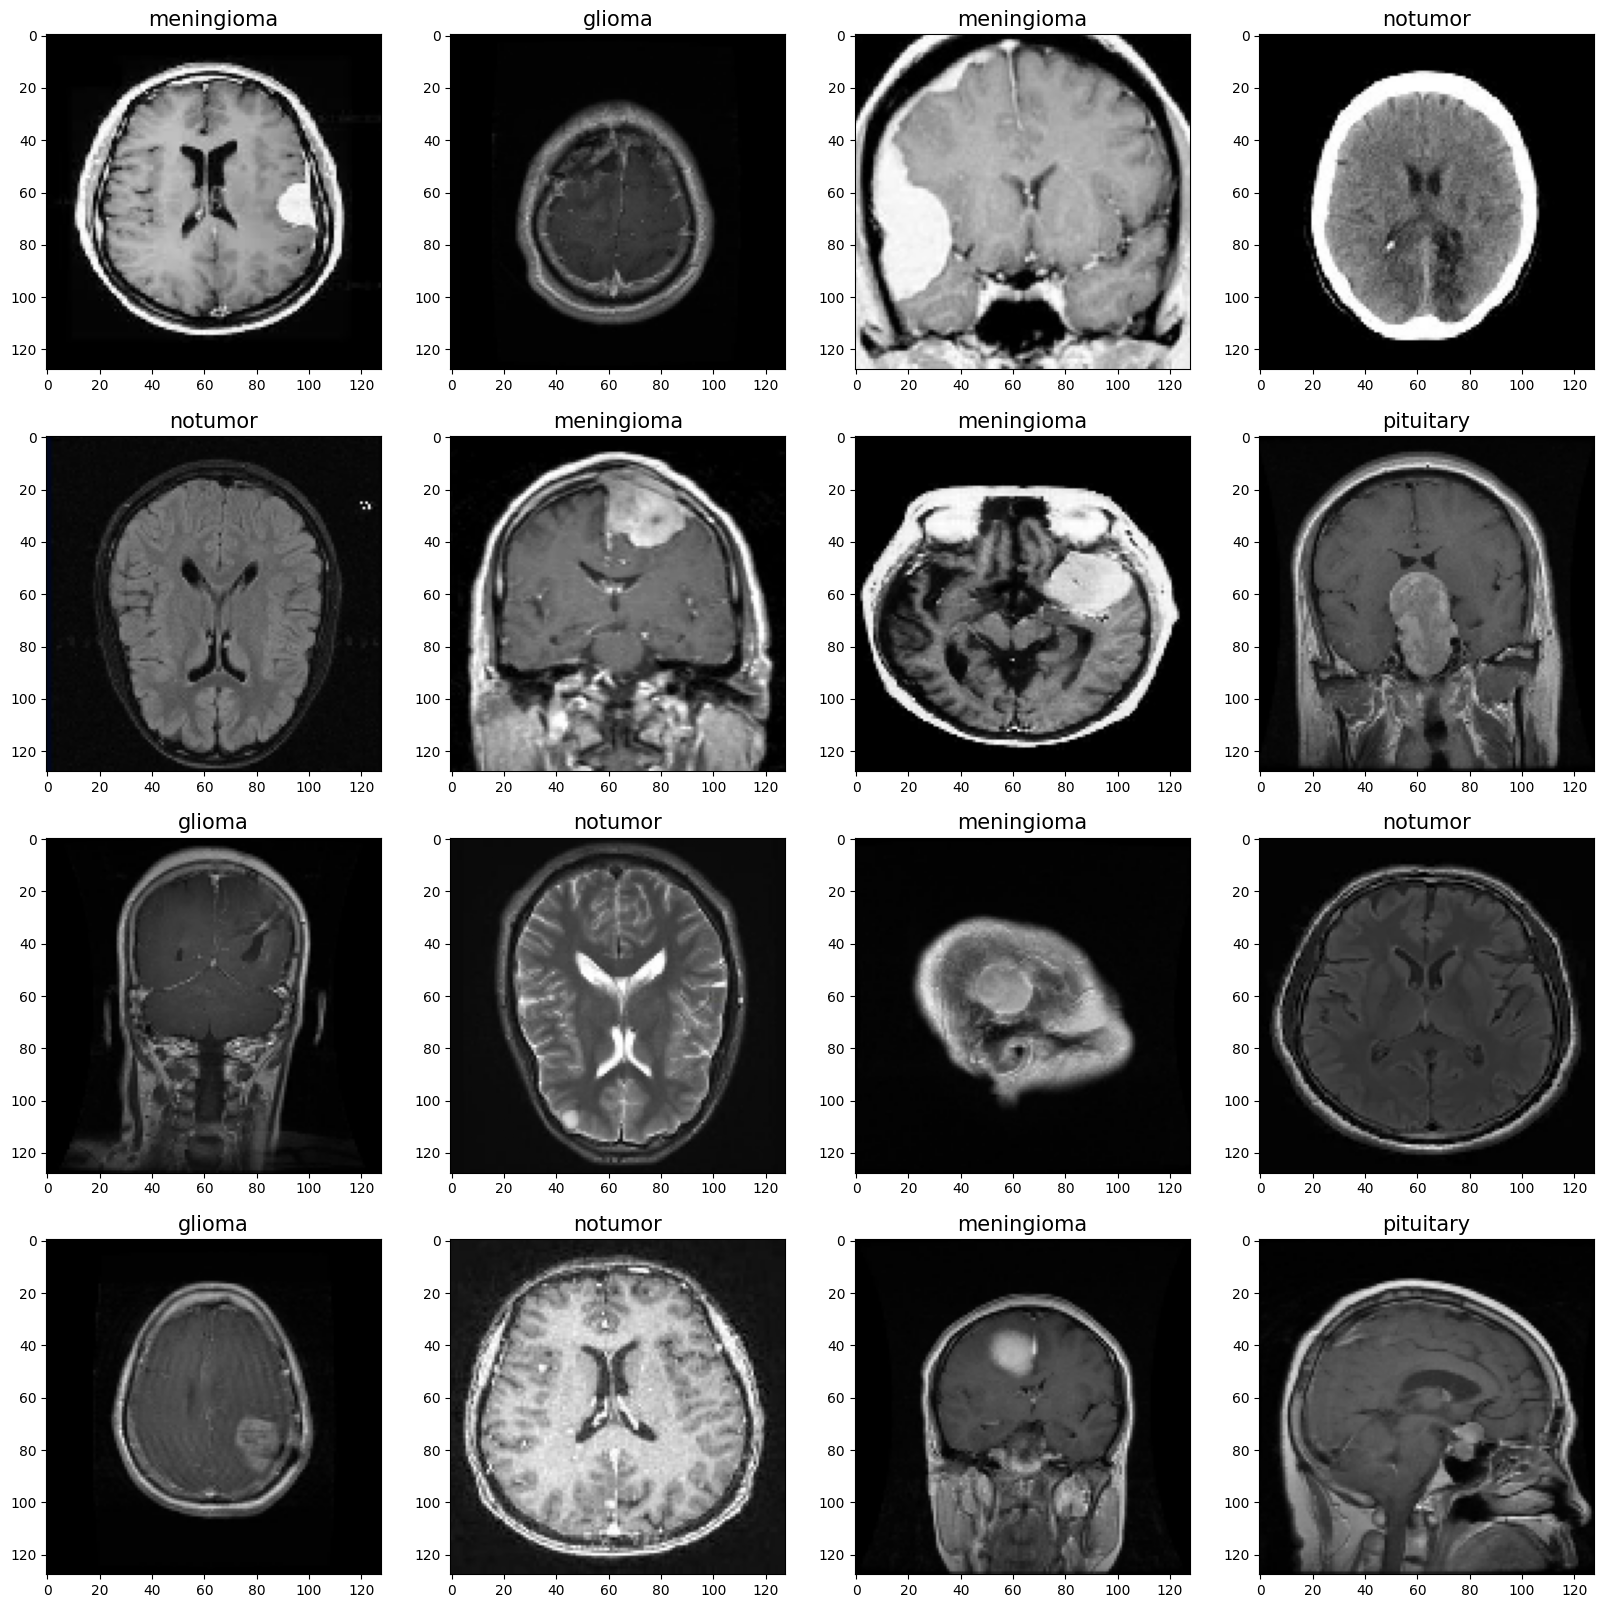

In [15]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

# 4. Training

In [16]:
img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 3)

#n_classes = df['category'].nunique()
n_classes = 4
print('Total number of unique categories:', n_classes)

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.layers import DepthwiseConv2D, SeparableConvolution2D, Convolution2D, Conv2D,GRU, LSTM, AlphaDropout, Embedding, ZeroPadding2D,AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.layers import Concatenate, Average, Maximum, Bidirectional, TimeDistributed
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
#from keras.engine.input_layer import Input
from keras.models import load_model
#from keras.initializers import LecunNormal

import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option('precision', 30)
np.set_printoptions(precision = 30)


#tf.set_random_seed(1090)

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
##from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
#print(os.listdir("../input/alzheimer-mri-dataset/Dataset"))
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose,Concatenate, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
print("TensorFlow Version:", tf.__version__)

Total number of unique categories: 4
TensorFlow Version: 2.17.0


## 

## Proposed Robust Information Fusion Attention (RIFA) 

In [17]:
## Proposed Robust Information Fusion Attention (RIFA) 

import tensorflow as tf
from tensorflow.keras import layers

class GlobalMinPooling2D(layers.Layer):
    def __init__(self, **kwargs):
        super(GlobalMinPooling2D, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.reduce_min(inputs, axis=[1, 2])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super(GlobalMinPooling2D, self).get_config()
        return config


class DeeperGlobalLocalAttentionLayer(layers.Layer):
    def __init__(self, units, activation='sigmoid', dropout_rate=0.2, use_scale=True, **kwargs):
        super(DeeperGlobalLocalAttentionLayer, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_scale = use_scale

    def build(self, input_shape):
        _, _, _, channels = input_shape
        self.global_avg_pooling = layers.GlobalAveragePooling2D()
        self.global_max_pooling = layers.GlobalMaxPooling2D()
        self.global_min_pooling = GlobalMinPooling2D()
        
        self.global_attention = layers.Dense(units=self.units, activation=self.activation)
        
        self.local_conv1 = layers.Conv2D(filters=self.units, kernel_size=(1, 1), activation=self.activation)
        self.local_conv2 = layers.Conv2D(filters=self.units, kernel_size=(1, 1), activation=self.activation)
        
        if self.use_scale:
            self.global_scale = self.add_weight(shape=(1, 1, 1, 1), initializer='ones', trainable=True, name='global_scale')
            self.local_scale = self.add_weight(shape=(1, 1, 1, self.units), initializer='ones', trainable=True, name='local_scale')
        
        super(DeeperGlobalLocalAttentionLayer, self).build(input_shape)

    def call(self, inputs, training=None):
        # Deeper Global Attention
        global_avg = self.global_avg_pooling(inputs)
        global_max = self.global_max_pooling(inputs)
        global_min = self.global_min_pooling(inputs)
        
        global_attention_avg = self.global_attention(global_avg)
        global_attention_avg = tf.expand_dims(tf.expand_dims(global_attention_avg, 1), 1)
        
        global_attention_max = self.global_attention(global_max)
        global_attention_max = tf.expand_dims(tf.expand_dims(global_attention_max, 1), 1)
        
        global_attention_min = self.global_attention(global_min)
        global_attention_min = tf.expand_dims(tf.expand_dims(global_attention_min, 1), 1)

        global_attention_add = global_attention_max + global_attention_avg + global_attention_min
        global_attention_sub = global_attention_max - global_attention_avg - global_attention_min

        global_attention = global_attention_add + global_attention_sub

        # Deeper Local Attention
        local_attention1 = self.local_conv1(inputs)
        local_attention1 = tf.reduce_mean(local_attention1, axis=[1, 2], keepdims=True)  # Reduce spatial dimensions
        local_attention2 = self.local_conv2(local_attention1)
        local_attention = tf.reduce_mean(local_attention2, axis=[1, 2], keepdims=True)  # Reduce spatial dimensions

        # Scale Global and Local Attention
        if self.use_scale:
            global_attention *= self.global_scale
            local_attention *= self.local_scale

        # Combine Global and Local Attention
        attention = tf.sigmoid(global_attention + local_attention)
        return attention

    def get_config(self):
        config = super(DeeperGlobalLocalAttentionLayer, self).get_config()
        config.update({'units': self.units, 'activation': self.activation, 'dropout_rate': self.dropout_rate,
                       'use_scale': self.use_scale})
        return config

class DeeperAttentionLayer(layers.Layer):
    def __init__(self, units=64, use_scale=True, **kwargs):
        super(DeeperAttentionLayer, self).__init__(**kwargs)
        self.units = units
        self.use_scale = use_scale

    def build(self, input_shape):
        _, H, W, C = input_shape
        self.alpha = self.add_weight(shape=(1, 1, 1, C), initializer='ones', trainable=True, name='alpha')
        self.deeper_global_local_attention = DeeperGlobalLocalAttentionLayer(units=self.units, activation='sigmoid', 
                                                                              dropout_rate=0.2,  # You can adjust the dropout rate
                                                                              use_scale=self.use_scale)
        super(DeeperAttentionLayer, self).build(input_shape)

    def call(self, inputs, training=None):
        attention = self.deeper_global_local_attention(inputs, training=training)
        attention_feature = inputs * attention * self.alpha
        return attention_feature

    def get_config(self):
        config = super(DeeperAttentionLayer, self).get_config()
        config.update({'units': self.units, 'use_scale': self.use_scale})
        return config


## Proposed RIFA-Net

In [20]:
## Proposed RIFA-Net

def residual_block(x, filters, strides=(1, 1), use_attention=True):  ### RA block
    filters1, filters2, filters3 = filters
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.1, channel_noise_factor=0.1)(x)
    
    #x = GlobalLocalAttention(x)
    
    x = Conv2D(filters3, (1, 1), strides=strides, padding='same'
               , use_bias=False, kernel_initializer='he_normal')(x)
    
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.01, 
     #                               channel_noise_factor=0.01)(x)
    
    #x = BatchNormalization()(x)
    #x = BatchNormalization()(x)
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=1.0, 
     #                               channel_noise_factor=1.0)(x)
   
    x_shortcut = x
    #print('x_shortcut shape:', x_shortcut.shape)
    
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=1.0, 
     #                               channel_noise_factor=1.0)(x)
    
    # First block
    
    x = Conv2D(filters1, (3, 3), strides=strides, padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    x = DeeperAttentionLayer(units=filters1, use_scale=True)(x) ## RIFA
    x = BatchNormalization()(x)
    
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.3, 
           #                         channel_noise_factor=0.3)(x)
   
    # Second block
    
    x = Conv2D(filters2, (3, 3), padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    #
    x = DeeperAttentionLayer(units=filters2, use_scale=True)(x) ## RIFA
    #
    x = BatchNormalization()(x)
    
    
    
    # Third block
    
    x = Conv2D(filters3, (3, 3), padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    x = DeeperAttentionLayer(units=filters3, use_scale=True)(x) ## RIFA
    
    x = BatchNormalization()(x)
    
    
    '''if strides != (1, 1) or x.shape[-1] != filters3:
        #x_shortcut = CombinedAttentionNoiseLayer(spatial_noise_factor=1.0, 
         #                           channel_noise_factor=1.0)(x_shortcut)
        #x_shortcut = GlobalLocalAttention(x_shortcut)
        x_shortcut = Conv2D(filters3, (1, 1), strides=strides, 
                            padding='same', use_bias=False, kernel_initializer='he_normal', 
                           # activation = 'relu'
                           )(x_shortcut)
        
        #x_shortcut = CombinedAttentionNoiseLayer(spatial_noise_factor=0.01, 
         #                           channel_noise_factor=0.01)(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)
    '''    
    
    # Add shortcut value to the main path
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.ReLU()(x)
    
    
    return x

def ResNet18(input_shape=(128, 128, 3), num_classes=4):
    input_tensor = Input(shape=input_shape)
    
    x = input_tensor
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    x = DeeperAttentionLayer(units=64, use_scale=True)(x) ## RIFA
    x = BatchNormalization()(x)
    #x = ReLU()(x)
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.3, 
     #                               channel_noise_factor=0.3)(x)
    
    x = MaxPooling2D((7,7), strides=(2, 2), padding='same')(x)
    
       
    # Residual blocks
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=2.0, 
     #                               channel_noise_factor=2.0)(x)
    
    #x = GlobalLocalAttention(x)
    x = residual_block(x, [64, 64, 256], strides=(1, 1))
    x = DeeperAttentionLayer(units=256, use_scale=True)(x) ## RIFA
    
    x = residual_block(x, [64, 64, 256])
    x = DeeperAttentionLayer(units=256, use_scale=True)(x) ## RIFA
    x = Dropout(0.5)(x, training = True)  ## Monte Carlo Dropout (MCD)
    
    #x = DeeperAttentionLayer(units=256, use_scale=True)(x)
    
    x = residual_block(x, [128, 128, 512])
    #x = DeeperAttentionLayer(units=512, use_scale=True)(x)
    x = Dropout(0.25)(x, training = True)  ## Monte Carlo Dropout

    
    
    #x = DeeperAttentionLayer(units=512, use_scale=True)(x)
    
    x = residual_block(x, [128, 128, 512])   
    x = DeeperAttentionLayer(units=512, use_scale=True)(x) ## RIFA
    
    
    
    # Global average pooling
    #x = AveragePooling2D((2, 2))(x)
    #x = GlobalAveragePooling2D()(x)
    
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
    x2 = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Add()([x1, x2])
    x = tf.keras.layers.ReLU()(x)
    
    #print('x:', x.shape)
    #x = Flatten()(x)
    
    
    x = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    
    return model

# Create ResNet-18 model
model = ResNet18()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
#model.fit(images_train, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
def checkpoint_callback():

    checkpoint_filepath = 'best_models1.keras'

    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           #frequency='epoch',
                           monitor='val_loss',
                           save_best_only=True,
                           verbose=1)

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback



checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=200)
callbacks = [checkpoint_callback, early_stopping]
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 64, 64, 64)     │          1,728 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deeper_attention_layer_32 │ (None, 64, 64, 64)     │         12,609 │ conv2d_98[0][0]        │
│ (DeeperAttentionLayer)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 64, 64, 64)     │            256 │ deeper_attention_laye… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 32, 32, 256)    │         16,384 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 32, 32, 64)     │        147,456 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deeper_attention_layer_33 │ (None, 32, 32, 64)     │         12,609 │ conv2d_102[0][0]       │
│ (DeeperAttentionLayer)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 32, 32, 64)     │            256 │ deeper_attention_laye… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 32, 32, 64)     │         36,864 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deeper_attention_layer_34 │ (None, 32, 32, 64)     │         12,609 │ conv2d_105[0][0]       │
│ (DeeperAttentionLayer)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 32, 32, 64)     │            256 │ deeper_attention_laye… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 32, 32, 256)    │        147,456 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deeper_attention_layer_35 │ (None, 32, 32, 256)    │        197,889 │ conv2d_108[0][0]       │
│ (DeeperAttentionLayer)    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_29    │ (None, 32, 32, 256)    │          1,024 │ deeper_attention_laye… │
│ (BatchNormalization) 

 Total params: 7,226,900 (27.57 MB)

 Trainable params: 7,222,164 (27.55 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [21]:
hist1 = model.fit(tr_gen,
                 epochs=100,
                 validation_data=valid_gen,callbacks = [callbacks],
                 shuffle= False)

Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.5611 - loss: 5.0945
Epoch 1: val_loss improved from inf to 2.71315, saving model to best_models1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 211s 874ms/step - accuracy: 0.5617 - loss: 5.0776 - val_accuracy: 0.3588 - val_loss: 2.7131
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7723 - loss: 0.7002
Epoch 2: val_loss improved from 2.71315 to 2.69059, saving model to best_models1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.7723 - loss: 0.7000 - val_accuracy: 0.4794 - val_loss: 2.6906
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8150 - loss: 0.5637
Epoch 3: val_loss improved from 2.69059 to 1.18049, saving model to best_models1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.8150 - loss: 0.5636 - val_accuracy: 0.6824 - val_loss: 1.1805
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8667 - loss: 0.4073
Epoch 4: val_loss did not 

In [ ]:
model.evaluate(ts_gen, verbose=1)
loaded_model = tf.keras.models.load_model('/kaggle/working/best_models1.h5', 
                                          custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
loaded_model.evaluate(ts_gen)

In [31]:
final_prediction_binary = loaded_model.predict(ts_gen, verbose = 0)
final_prediction_labels = np.argmax(final_prediction_binary, axis=1)
final_prediction_labels.shape, final_prediction_binary.shape

((656,), (656, 4))

In [36]:
true_labels = ts_gen.classes
#true_labels
true_labels_array = np.array(true_labels)
true_labels_array.shape

(656,)

In [ ]:
final_prediction_binary = loaded_model.predict(ts_gen, verbose = 0)
final_prediction_labels = np.argmax(final_prediction_binary, axis=1)
final_prediction_labels.shape, final_prediction_binary.shape
y_test2 = true_labels_array
ensemble_f1 = f1_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble F1 Score:", ensemble_f1)
ensemble_prec = precision_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble prec Score:", ensemble_prec)
ensemble_rec = recall_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble rec Score:", ensemble_rec)

ensemble_acc = accuracy_score(y_test2, final_prediction_labels)
print("Ensemble ACC Score:", ensemble_acc)
from sklearn.metrics import roc_auc_score
#ensemble_f1 = roc_auc_score(y_test2, final_prediction_labels, multi_class='ovr')
print("Ensemble F1 Score:", ensemble_f1)


In [76]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Assuming final_prediction_labels are your predicted labels

ensemble_f1 = f1_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble F1 Score:", ensemble_f1)

ensemble_prec = precision_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble Precision Score:", ensemble_prec)

ensemble_rec = recall_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble Recall Score:", ensemble_rec)

ensemble_acc = accuracy_score(y_test2, final_prediction_labels)
print("Ensemble Accuracy Score:", ensemble_acc)

#ensemble_roc_auc = roc_auc_score(y_test2, final_prediction_labels, average='macro', multi_class='ovr')
#print("Ensemble ROC AUC Score:", ensemble_roc_auc)

# Classification Report
print("Classification Report:")
print(classification_report(y_test2, final_prediction_labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test2, final_prediction_labels))

# Calculate PPV, Specificity, Sensitivity


Ensemble F1 Score: 0.9836703708230636
Ensemble Precision Score: 0.9838407349694844
Ensemble Recall Score: 0.9835294117647059
Ensemble Accuracy Score: 0.9847560975609756
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       150
           1       0.97      0.96      0.97       153
           2       1.00      1.00      1.00       203
           3       0.99      0.99      0.99       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656

Confusion Matrix:
[[147   3   0   0]
 [  3 147   1   2]
 [  0   0 203   0]
 [  0   1   0 149]]


In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Assuming final_prediction_labels are your predicted labels

ensemble_f1 = f1_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble F1 Score:", ensemble_f1)

ensemble_prec = precision_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble Precision Score:", ensemble_prec)

ensemble_rec = recall_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble Recall Score:", ensemble_rec)

ensemble_acc = accuracy_score(y_test2, final_prediction_labels)
print("Ensemble Accuracy Score:", ensemble_acc)

#ensemble_roc_auc = roc_auc_score(y_test2, final_prediction_labels, average='macro', multi_class='ovr')
#print("Ensemble ROC AUC Score:", ensemble_roc_auc)

# Classification Report
print("Classification Report:")
print(classification_report(y_test2, final_prediction_labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test2, final_prediction_labels))

# Calculate PPV, Specificity, Sensitivity


Ensemble F1 Score: 0.9804660187751766
Ensemble Precision Score: 0.9809565976502497
Ensemble Recall Score: 0.9801307189542483
Ensemble Accuracy Score: 0.9817073170731707
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.95      0.97      0.96       153
           2       1.00      1.00      1.00       203
           3       0.99      0.97      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656

Confusion Matrix:
[[146   4   0   0]
 [  2 149   1   1]
 [  0   0 203   0]
 [  0   4   0 146]]


In [46]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate confusion matrix
cm = confusion_matrix(y_test2, final_prediction_labels)

# Calculate precision, recall, f1-score, and support for each class
precision, recall, fscore, support = precision_recall_fscore_support(y_test2, final_prediction_labels)

# Calculate PPV (Positive Predictive Value) for each class
ppv = precision

# Calculate specificity for each class
specificity = []
for i in range(cm.shape[0]):
    true_negative = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    false_positive = np.sum(cm[:, i]) - cm[i, i]
    specificity.append(true_negative / (true_negative + false_positive))

# Calculate sensitivity for each class
sensitivity = recall

# Print metrics for each class
for i in range(len(ppv)):
    print(f"Class {i}:")
    print("PPV (Positive Predictive Value):", ppv[i])
    print("Specificity:", specificity[i])
    print("Sensitivity:", sensitivity[i])
    print()


Class 0:
PPV (Positive Predictive Value): 0.9864864864864865
Specificity: 0.9960474308300395
Sensitivity: 0.9733333333333334

Class 1:
PPV (Positive Predictive Value): 0.9490445859872612
Specificity: 0.9840954274353877
Sensitivity: 0.9738562091503268

Class 2:
PPV (Positive Predictive Value): 0.9950980392156863
Specificity: 0.9977924944812362
Sensitivity: 1.0

Class 3:
PPV (Positive Predictive Value): 0.9931972789115646
Specificity: 0.9980237154150198
Sensitivity: 0.9733333333333334



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Uncertainty-RIFA-Net

In [52]:
def residual_block(x, filters, strides=(1, 1), use_attention=True):
    filters1, filters2, filters3 = filters
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.1, channel_noise_factor=0.1)(x)
    
    #x = GlobalLocalAttention(x)
    
    x = Conv2D(filters3, (1, 1), strides=strides, padding='same'
               , use_bias=False, kernel_initializer='he_normal')(x)
    
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.01, 
     #                               channel_noise_factor=0.01)(x)
    
    #x = BatchNormalization()(x)
    #x = BatchNormalization()(x)
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=1.0, 
     #                               channel_noise_factor=1.0)(x)
   
    x_shortcut = x
    #print('x_shortcut shape:', x_shortcut.shape)
    
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=1.0, 
     #                               channel_noise_factor=1.0)(x)
    
    # First block
    
    x = Conv2D(filters1, (3, 3), strides=strides, padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    x = DeeperAttentionLayer(units=filters1, use_scale=True)(x)
    x = BatchNormalization()(x)
    
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.3, 
           #                         channel_noise_factor=0.3)(x)
   
    # Second block
    
    x = Conv2D(filters2, (3, 3), padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    #
    x = DeeperAttentionLayer(units=filters2, use_scale=True)(x)
    #
    x = BatchNormalization()(x)
    
    
    
    # Third block
    
    x = Conv2D(filters3, (3, 3), padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    x = DeeperAttentionLayer(units=filters3, use_scale=True)(x)
    
    x = BatchNormalization()(x)
    
    
    '''if strides != (1, 1) or x.shape[-1] != filters3:
        #x_shortcut = CombinedAttentionNoiseLayer(spatial_noise_factor=1.0, 
         #                           channel_noise_factor=1.0)(x_shortcut)
        #x_shortcut = GlobalLocalAttention(x_shortcut)
        x_shortcut = Conv2D(filters3, (1, 1), strides=strides, 
                            padding='same', use_bias=False, kernel_initializer='he_normal', 
                           # activation = 'relu'
                           )(x_shortcut)
        
        #x_shortcut = CombinedAttentionNoiseLayer(spatial_noise_factor=0.01, 
         #                           channel_noise_factor=0.01)(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)
    '''    
    
    # Add shortcut value to the main path
    x = tf.keras.layers.Add()([x, x_shortcut])
    x = tf.keras.layers.ReLU()(x)
    
    
    return x

def ResNet18(input_shape=(128, 128, 3), num_classes=4):
    input_tensor = Input(shape=input_shape)
    
    x = input_tensor
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same'
              , use_bias=False, kernel_initializer='he_normal', activation = 'relu')(x)
    x = DeeperAttentionLayer(units=64, use_scale=True)(x)
    x = BatchNormalization()(x)
    #x = ReLU()(x)
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=0.3, 
     #                               channel_noise_factor=0.3)(x)
    
    x = MaxPooling2D((7,7), strides=(2, 2), padding='same')(x)
    
       
    # Residual blocks
    #x = CombinedAttentionNoiseLayer(spatial_noise_factor=2.0, 
     #                               channel_noise_factor=2.0)(x)
    
    #x = GlobalLocalAttention(x)
    x = residual_block(x, [64, 64, 256], strides=(1, 1))
    x = DeeperAttentionLayer(units=256, use_scale=True)(x)
    
    x = residual_block(x, [64, 64, 256])
    x = DeeperAttentionLayer(units=256, use_scale=True)(x)
    x = Dropout(0.5)(x, training = True)
    
    #x = DeeperAttentionLayer(units=256, use_scale=True)(x)
    
    x = residual_block(x, [128, 128, 512])
    #x = DeeperAttentionLayer(units=512, use_scale=True)(x)
    x = Dropout(0.25)(x, training = True)
    
    #x = DeeperAttentionLayer(units=512, use_scale=True)(x)
    
    x = residual_block(x, [128, 128, 512])   
    x = DeeperAttentionLayer(units=512, use_scale=True)(x)
    
    
    
    # Global average pooling
    #x = AveragePooling2D((2, 2))(x)
    #x = GlobalAveragePooling2D()(x)
    
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x)
    x2 = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Add()([x1, x2])
    x = tf.keras.layers.ReLU()(x)
    
    #print('x:', x.shape)
    #x = Flatten()(x)
    
    
    x = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    
    return model

### Uncertainty quantification of RIFA-Net

In [53]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import KLDivergence

# Set a random seed for reproducibility
np.random.seed(42)

def create_ensemble(num_models, input_shape=(128, 128, 3), num_classes=4, dropout_rate=0.25):
    ensemble_models = []
    
    for _ in range(num_models):
        model = ResNet18()  # Assuming ResNet18 is defined elsewhere
        ensemble_models.append(model)
    
    return ensemble_models

# Function to perform Monte Carlo Dropout inference

# Example usage
input_shape = (128, 128, 3)
num_classes = 4
num_models = 5
dropout_rate = 0.25

ensemble_models = create_ensemble(num_models, input_shape, num_classes, dropout_rate)

# Train each model in the ensemble
for i, model in enumerate(ensemble_models):
    print("Training Model", i)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define checkpoint callback for each model
    checkpoint = ModelCheckpoint(f"best_model_{i}.h5", monitor='val_loss', 
                                 verbose=1, save_best_only=True, mode='min')
    
    #model.fit(X_train1, y_train1, epochs=200, callbacks=[checkpoint], 
              #validation_split=0.2, verbose=0)
    model.fit(tr_gen,
                 epochs=200,
                 validation_data=valid_gen,callbacks = [checkpoint], verbose=0,
                 shuffle= False)

Training Model 0


2024-02-03 02:08:07.935417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 02:09:00.116163: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 2.42810, saving model to best_model_0.h5

Epoch 2: val_loss did not improve from 2.42810

Epoch 3: val_loss improved from 2.42810 to 1.85600, saving model to best_model_0.h5

Epoch 4: val_loss improved from 1.85600 to 0.66571, saving model to best_model_0.h5

Epoch 5: val_loss did not improve from 0.66571

Epoch 6: val_loss did not improve from 0.66571

Epoch 7: val_loss did not improve from 0.66571

Epoch 8: val_loss improved from 0.66571 to 0.39311, saving model to best_model_0.h5

Epoch 9: val_loss did not improve from 0.39311

Epoch 10: val_loss did not improve from 0.39311

Epoch 11: val_loss improved from 0.39311 to 0.35104, saving model to best_model_0.h5

Epoch 12: val_loss did not improve from 0.35104

Epoch 13: val_loss did not improve from 0.35104

Epoch 14: val_loss did not improve from 0.35104

Epoch 15: val_loss did not improve from 0.35104

Epoch 16: val_loss did not improve from 0.35104

Epoch 17: val_loss did not improve from 0.3

2024-02-03 04:01:43.758492: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 04:02:36.934664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 5.70490, saving model to best_model_1.h5

Epoch 2: val_loss improved from 5.70490 to 1.52092, saving model to best_model_1.h5

Epoch 3: val_loss did not improve from 1.52092

Epoch 4: val_loss improved from 1.52092 to 0.72827, saving model to best_model_1.h5

Epoch 5: val_loss did not improve from 0.72827

Epoch 6: val_loss did not improve from 0.72827

Epoch 7: val_loss improved from 0.72827 to 0.61133, saving model to best_model_1.h5

Epoch 8: val_loss improved from 0.61133 to 0.53450, saving model to best_model_1.h5

Epoch 9: val_loss improved from 0.53450 to 0.38967, saving model to best_model_1.h5

Epoch 10: val_loss did not improve from 0.38967

Epoch 11: val_loss improved from 0.38967 to 0.32318, saving model to best_model_1.h5

Epoch 12: val_loss did not improve from 0.32318

Epoch 13: val_loss improved from 0.32318 to 0.20209, saving model to best_model_1.h5

Epoch 14: val_loss did not improve from 0.20209

Epoch 15: val_loss did not imp

2024-02-03 05:55:44.418699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 05:56:36.365227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 2.18472, saving model to best_model_2.h5

Epoch 2: val_loss did not improve from 2.18472

Epoch 3: val_loss improved from 2.18472 to 0.87587, saving model to best_model_2.h5

Epoch 4: val_loss did not improve from 0.87587

Epoch 5: val_loss improved from 0.87587 to 0.73548, saving model to best_model_2.h5

Epoch 6: val_loss improved from 0.73548 to 0.51548, saving model to best_model_2.h5

Epoch 7: val_loss improved from 0.51548 to 0.48004, saving model to best_model_2.h5

Epoch 8: val_loss did not improve from 0.48004

Epoch 9: val_loss improved from 0.48004 to 0.32777, saving model to best_model_2.h5

Epoch 10: val_loss did not improve from 0.32777

Epoch 11: val_loss improved from 0.32777 to 0.29214, saving model to best_model_2.h5

Epoch 12: val_loss did not improve from 0.29214

Epoch 13: val_loss improved from 0.29214 to 0.24435, saving model to best_model_2.h5

Epoch 14: val_loss did not improve from 0.24435

Epoch 15: val_loss did not imp

2024-02-03 07:49:40.537760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 07:50:32.832472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 4.64583, saving model to best_model_3.h5

Epoch 2: val_loss did not improve from 4.64583

Epoch 3: val_loss improved from 4.64583 to 1.41795, saving model to best_model_3.h5

Epoch 4: val_loss improved from 1.41795 to 1.34280, saving model to best_model_3.h5

Epoch 5: val_loss improved from 1.34280 to 0.68650, saving model to best_model_3.h5

Epoch 6: val_loss did not improve from 0.68650

Epoch 7: val_loss improved from 0.68650 to 0.38495, saving model to best_model_3.h5

Epoch 8: val_loss did not improve from 0.38495

Epoch 9: val_loss did not improve from 0.38495

Epoch 10: val_loss did not improve from 0.38495

Epoch 11: val_loss improved from 0.38495 to 0.34219, saving model to best_model_3.h5

Epoch 12: val_loss did not improve from 0.34219

Epoch 13: val_loss did not improve from 0.34219

Epoch 14: val_loss improved from 0.34219 to 0.31329, saving model to best_model_3.h5

Epoch 15: val_loss did not improve from 0.31329

Epoch 16: val_loss

2024-02-03 09:43:40.718556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 09:44:33.710190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 2.92770, saving model to best_model_4.h5

Epoch 2: val_loss did not improve from 2.92770

Epoch 3: val_loss improved from 2.92770 to 1.59115, saving model to best_model_4.h5

Epoch 4: val_loss improved from 1.59115 to 0.61920, saving model to best_model_4.h5

Epoch 5: val_loss improved from 0.61920 to 0.51214, saving model to best_model_4.h5

Epoch 6: val_loss did not improve from 0.51214

Epoch 7: val_loss did not improve from 0.51214

Epoch 8: val_loss did not improve from 0.51214

Epoch 9: val_loss did not improve from 0.51214

Epoch 10: val_loss improved from 0.51214 to 0.43514, saving model to best_model_4.h5

Epoch 11: val_loss improved from 0.43514 to 0.42271, saving model to best_model_4.h5

Epoch 12: val_loss did not improve from 0.42271

Epoch 13: val_loss improved from 0.42271 to 0.25078, saving model to best_model_4.h5

Epoch 14: val_loss did not improve from 0.25078

Epoch 15: val_loss improved from 0.25078 to 0.23756, saving model t

In [56]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import KLDivergence
ensemble_models_0 = load_model('/kaggle/working/best_model_0.h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_1 = load_model('/kaggle/working/best_model_1.h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_2 = load_model('/kaggle/working/best_model_2.h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_3 = load_model('/kaggle/working/best_model_3.h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_4 = load_model('/kaggle/working/best_model_4.h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
'''ensemble_models_5 = load_model('/kaggle/input/vgg16-data-deep-el-model/vgg16_ensemble_models5.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_6 = load_model('/kaggle/input/vgg16-data-deep-el-model/vgg16_ensemble_models6.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_7 = load_model('/kaggle/input/updated-vgg16-el-models/ensemble_models7.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_8 = load_model('/kaggle/input/updated-vgg16-el-models/ensemble_models8.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_9 = load_model('/kaggle/input/updated-vgg16-el-models/ensemble_models9.h5', custom_objects={'distillation_loss': distillation_loss})
'''
ensemble_models_0.evaluate(ts_gen)
ensemble_models_1.evaluate(ts_gen)
ensemble_models_2.evaluate(ts_gen)
ensemble_models_3.evaluate(ts_gen)
ensemble_models_4.evaluate(ts_gen)
'''ensemble_models_5.evaluate([X_test], y_test)
ensemble_models_6.evaluate([X_test], y_test)
ensemble_models_7.evaluate([X_test], y_test)
ensemble_models_8.evaluate([X_test], y_test)
ensemble_models_9.evaluate([X_test], y_test)'''

2024-02-03 11:45:01.070258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 6s 122ms/step - loss: 0.0901 - accuracy: 0.9832


2024-02-03 11:45:07.096963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 3s 38ms/step - loss: 0.1647 - accuracy: 0.9649


2024-02-03 11:45:09.783460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 2s 35ms/step - loss: 0.1413 - accuracy: 0.9756


2024-02-03 11:45:12.297801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 2s 35ms/step - loss: 0.0897 - accuracy: 0.9726


2024-02-03 11:45:14.838019: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 3s 56ms/step - loss: 0.0948 - accuracy: 0.9817


'ensemble_models_5.evaluate([X_test], y_test)\nensemble_models_6.evaluate([X_test], y_test)\nensemble_models_7.evaluate([X_test], y_test)\nensemble_models_8.evaluate([X_test], y_test)\nensemble_models_9.evaluate([X_test], y_test)'

In [33]:
ensemble_models = []

# Assuming ensemble_models_1, ..., ensemble_models_9 are your model variables
# Replace these lines with your actual model variables
ensemble_models.append(ensemble_models_0)
ensemble_models.append(ensemble_models_1)
ensemble_models.append(ensemble_models_2)
ensemble_models.append(ensemble_models_3)
ensemble_models.append(ensemble_models_4)
'''ensemble_models.append(ensemble_models_5)
ensemble_models.append(ensemble_models_6)
ensemble_models.append(ensemble_models_7)
ensemble_models.append(ensemble_models_8)
ensemble_models.append(ensemble_models_9)
'''
# Now you can use a for loop to iterate over the ensemble_models list
#for model in ensemble_models:
    # Perform some operation with each model, e.g., make predictions or evaluate
    #predictions = model.predict(some_data)
    # Add your logic here


'ensemble_models.append(ensemble_models_5)\nensemble_models.append(ensemble_models_6)\nensemble_models.append(ensemble_models_7)\nensemble_models.append(ensemble_models_8)\nensemble_models.append(ensemble_models_9)\n'

In [34]:
ensemble_models

In [ ]:
def monte_carlo_dropout_inference(model, x, num_samples=500):
    predictions = np.zeros((num_samples,) + model.predict(x, verbose = 0).shape)

    for i in range(num_samples):
        #print(i)
        predictions[i, :] = model.predict(x, verbose = 0)

    return predictions

# Perform Monte Carlo Dropout inference for each model in the ensemble
ensemble_predictions = []
for model in ensemble_models:
    predictions = monte_carlo_dropout_inference(model, ts_gen)
    ensemble_predictions.append(predictions)

# Take the mean or other aggregation method across the ensemble predictions
final_prediction = np.mean(ensemble_predictions, axis=0)

# Use the final_prediction for further analysis or decision making
print("Final Prediction:", final_prediction.shape)


In [41]:
final_prediction.shape

(500, 656, 4)

In [42]:
final_prediction_binary = np.mean(final_prediction, axis=0)
final_prediction_labels = np.argmax(final_prediction_binary, axis=1)
final_prediction_binary.shape, final_prediction_labels.shape

((656, 4), (656,))

In [43]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

# Assuming final_prediction_labels are your predicted labels

# Calculate F1 score
f1 = f1_score(y_test2, final_prediction_labels, average='macro')
print("F1 Score:", f1)

# Calculate precision
precision = precision_score(y_test2, final_prediction_labels, average='macro')
print("Precision Score:", precision)

# Calculate recall
recall = recall_score(y_test2, final_prediction_labels, average='macro')
print("Recall Score:", recall)

# Calculate accuracy
accuracy = accuracy_score(y_test2, final_prediction_labels)
print("Accuracy Score:", accuracy)

# Calculate specificity, sensitivity, and PPV for each class
cm = confusion_matrix(y_test2, final_prediction_labels)
num_classes = cm.shape[0]
specificity = []
sensitivity = []
ppv = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(cm, i, axis=0)[:, np.delete(np.arange(num_classes), i)])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    false_negatives = np.sum(cm[i, :]) - cm[i, i]
    true_positives = cm[i, i]
    
    # Specificity (True Negative Rate)
    specificity.append(true_negatives / (true_negatives + false_positives))

    # Sensitivity (Recall)
    sensitivity.append(true_positives / (true_positives + false_negatives))
    
    # PPV (Positive Predictive Value)
    ppv.append(true_positives / (true_positives + false_positives))

# Print specificity, sensitivity, and PPV for each class
for i in range(num_classes):
    print(f"Class {i}:")
    print("Specificity:", specificity[i])
    print("Sensitivity:", sensitivity[i])
    print("PPV (Positive Predictive Value):", ppv[i])
    print()

# Classification Report
print("Classification Report:")
print(classification_report(y_test2, final_prediction_labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test2, final_prediction_labels))


F1 Score: 0.977850479650187
Precision Score: 0.9777123898920265
Recall Score: 0.9781354840786889
Accuracy Score: 0.9786585365853658
Class 0:
Specificity: 0.9960474308300395
Sensitivity: 0.9666666666666667
PPV (Positive Predictive Value): 0.9863945578231292

Class 1:
Specificity: 0.9821073558648111
Sensitivity: 0.9673202614379085
PPV (Positive Predictive Value): 0.9426751592356688

Class 2:
Specificity: 0.9977924944812362
Sensitivity: 0.9852216748768473
PPV (Positive Predictive Value): 0.9950248756218906

Class 3:
Specificity: 0.9960474308300395
Sensitivity: 0.9933333333333333
PPV (Positive Predictive Value): 0.9867549668874173

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.94      0.97      0.95       153
           2       1.00      0.99      0.99       203
           3       0.99      0.99      0.99       150

    accuracy                           0.98       656
   macro avg   

In [67]:
final_prediction_binary = np.mean(final_prediction, axis=0)
final_prediction_labels = np.argmax(final_prediction_binary, axis=1)
final_prediction_binary.shape, final_prediction_labels.shape

((656, 4), (656,))

In [38]:
print(f1_score(y_test2, final_prediction_labels, average='macro'))
print(precision_score(y_test2, final_prediction_labels, average='macro'))
print(recall_score(y_test2, final_prediction_labels, average='macro'))
print(accuracy_score(y_test2, final_prediction_labels))

0.977850479650187
0.9777123898920265
0.9781354840786889
0.9786585365853658


In [71]:
print(f1_score(y_test2, final_prediction_labels, average='macro'))
print(precision_score(y_test2, final_prediction_labels, average='macro'))
print(recall_score(y_test2, final_prediction_labels, average='macro'))
print(accuracy_score(y_test2, final_prediction_labels))

0.977850479650187
0.9777123898920265
0.9781354840786889
0.9786585365853658


In [73]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

# Assuming final_prediction_labels are your predicted labels

# Calculate F1 score
f1 = f1_score(y_test2, final_prediction_labels, average='macro')
print("F1 Score:", f1)

# Calculate precision
precision = precision_score(y_test2, final_prediction_labels, average='macro')
print("Precision Score:", precision)

# Calculate recall
recall = recall_score(y_test2, final_prediction_labels, average='macro')
print("Recall Score:", recall)

# Calculate accuracy
accuracy = accuracy_score(y_test2, final_prediction_labels)
print("Accuracy Score:", accuracy)

# Calculate specificity, sensitivity, and PPV for each class
cm = confusion_matrix(y_test2, final_prediction_labels)
num_classes = cm.shape[0]
specificity = []
sensitivity = []
ppv = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(cm, i, axis=0)[:, np.delete(np.arange(num_classes), i)])
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    false_negatives = np.sum(cm[i, :]) - cm[i, i]
    true_positives = cm[i, i]
    
    # Specificity (True Negative Rate)
    specificity.append(true_negatives / (true_negatives + false_positives))

    # Sensitivity (Recall)
    sensitivity.append(true_positives / (true_positives + false_negatives))
    
    # PPV (Positive Predictive Value)
    ppv.append(true_positives / (true_positives + false_positives))

# Print specificity, sensitivity, and PPV for each class
for i in range(num_classes):
    print(f"Class {i}:")
    print("Specificity:", specificity[i])
    print("Sensitivity:", sensitivity[i])
    print("PPV (Positive Predictive Value):", ppv[i])
    print()

# Classification Report
print("Classification Report:")
print(classification_report(y_test2, final_prediction_labels))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test2, final_prediction_labels))


F1 Score: 0.977850479650187
Precision Score: 0.9777123898920265
Recall Score: 0.9781354840786889
Accuracy Score: 0.9786585365853658
Class 0:
Specificity: 0.9960474308300395
Sensitivity: 0.9666666666666667
PPV (Positive Predictive Value): 0.9863945578231292

Class 1:
Specificity: 0.9821073558648111
Sensitivity: 0.9673202614379085
PPV (Positive Predictive Value): 0.9426751592356688

Class 2:
Specificity: 0.9977924944812362
Sensitivity: 0.9852216748768473
PPV (Positive Predictive Value): 0.9950248756218906

Class 3:
Specificity: 0.9960474308300395
Sensitivity: 0.9933333333333333
PPV (Positive Predictive Value): 0.9867549668874173

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.94      0.97      0.95       153
           2       1.00      0.99      0.99       203
           3       0.99      0.99      0.99       150

    accuracy                           0.98       656
   macro avg   

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import KLDivergence
ensemble_models_0 = load_model('/kaggle/input/bran-ds2-combined-el/best_model_0(1).h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_1 = load_model('/kaggle/input/bran-ds2-combined-el/best_model_1(1).h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_2 = load_model('/kaggle/input/bran-ds2-combined-el/best_model_2(1).h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_3 = load_model('/kaggle/input/bran-ds2-combined-el/best_model_3(1).h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
ensemble_models_4 = load_model('/kaggle/input/bran-ds2-combined-el/best_model_4.h5', custom_objects = {'DeeperAttentionLayer': DeeperAttentionLayer})
'''ensemble_models_5 = load_model('/kaggle/input/vgg16-data-deep-el-model/vgg16_ensemble_models5.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_6 = load_model('/kaggle/input/vgg16-data-deep-el-model/vgg16_ensemble_models6.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_7 = load_model('/kaggle/input/updated-vgg16-el-models/ensemble_models7.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_8 = load_model('/kaggle/input/updated-vgg16-el-models/ensemble_models8.h5', custom_objects={'distillation_loss': distillation_loss})
ensemble_models_9 = load_model('/kaggle/input/updated-vgg16-el-models/ensemble_models9.h5', custom_objects={'distillation_loss': distillation_loss})
'''
ensemble_models_0.evaluate(ts_gen)
ensemble_models_1.evaluate(ts_gen)
ensemble_models_2.evaluate(ts_gen)
ensemble_models_3.evaluate(ts_gen)
ensemble_models_4.evaluate(ts_gen)
'''ensemble_models_5.evaluate([X_test], y_test)
ensemble_models_6.evaluate([X_test], y_test)
ensemble_models_7.evaluate([X_test], y_test)
ensemble_models_8.evaluate([X_test], y_test)
ensemble_models_9.evaluate([X_test], y_test)'''

2024-02-03 12:44:23.318022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 2s 35ms/step - loss: 0.0683 - accuracy: 0.9848


2024-02-03 12:44:25.902053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 3s 36ms/step - loss: 0.1546 - accuracy: 0.9649


2024-02-03 12:44:28.527466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 2s 34ms/step - loss: 0.1654 - accuracy: 0.9741


2024-02-03 12:44:31.060726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 3s 36ms/step - loss: 0.0944 - accuracy: 0.9695


2024-02-03 12:44:33.705610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - 3s 38ms/step - loss: 0.1251 - accuracy: 0.9771


'ensemble_models_5.evaluate([X_test], y_test)\nensemble_models_6.evaluate([X_test], y_test)\nensemble_models_7.evaluate([X_test], y_test)\nensemble_models_8.evaluate([X_test], y_test)\nensemble_models_9.evaluate([X_test], y_test)'

In [32]:
final_prediction_binary = ensemble_models_0.predict(ts_gen, verbose = 0)
final_prediction_labels = np.argmax(final_prediction_binary, axis=1)
final_prediction_labels.shape, final_prediction_binary.shape
true_labels = ts_gen.classes
#true_labels
true_labels_array = np.array(true_labels)
true_labels_array.shape
y_test2 = true_labels_array
ensemble_f1 = f1_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble F1 Score:", ensemble_f1)
ensemble_prec = precision_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble prec Score:", ensemble_prec)
ensemble_rec = recall_score(y_test2, final_prediction_labels, average='macro')
print("Ensemble rec Score:", ensemble_rec)

ensemble_acc = accuracy_score(y_test2, final_prediction_labels)
print("Ensemble ACC Score:", ensemble_acc)
from sklearn.metrics import roc_auc_score
#ensemble_f1 = roc_auc_score(y_test2, final_prediction_labels, multi_class='ovr')
print("Ensemble F1 Score:", ensemble_f1)


Ensemble F1 Score: 0.9820917279929223
Ensemble prec Score: 0.9819264069264069
Ensemble rec Score: 0.9822652049325477
Ensemble ACC Score: 0.9832317073170732
Ensemble F1 Score: 0.9820917279929223


In [45]:
import time

# Assuming ts_gen is your test generator containing the image
start_time = time.time()
final_prediction_binary = ensemble_models_0.predict(ts_gen, verbose=0)
end_time = time.time()

# Calculate the inference time for one image
inference_time_per_image = (end_time - start_time) / len(ts_gen)

print("Inference time per image: {:.5f} seconds".format(inference_time_per_image))


Inference time per image: 0.03815 seconds
